In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from _bus_cost_utils import GCS_PATH, new_outlier_flag_v2
from IPython.display import Markdown, display, HTML
from matplotlib.ticker import ScalarFormatter
from scipy.stats import zscore
from IPython.display import Markdown, display

pd.set_option("display.max_rows", 300)
pd.set_option('display.max_colwidth', None)

In [2]:
merged_data = pd.read_parquet(f'{GCS_PATH}cleaned_no_outliers_cpb_analysis_data_merge.parquet')

In [3]:
# for subsetting ZEB and nonZEB
zeb_list =[
    "BEB",
    "FCEB",
    "electric (not specified)",
    "zero-emission bus (not specified)",
]

non_zeb_list =[
    "CNG",
    "ethanol",
    "low emission (hybrid)",
    "low emission (propane)",
    "mix (zero and low emission)",
]

In [4]:
# means and standard deviations
# for graphs
cpb_mean = merged_data["cost_per_bus"].mean()
cpb_std = merged_data["cost_per_bus"].std()

#testing weighted average calculation for sub-set non-zeb and zeb
zeb_cpb_wt_avg = (merged_data[merged_data["prop_type"].isin(zeb_list)]["total_cost"].sum() / merged_data[merged_data["prop_type"].isin(zeb_list)]["bus_count"].sum())
non_zeb_cpb_wt_avg = (merged_data[merged_data["prop_type"].isin(non_zeb_list)]["total_cost"].sum() / merged_data[merged_data["prop_type"].isin(non_zeb_list)]["bus_count"].sum())

In [5]:
def bus_cost_totals(df:pd.DataFrame, col: str) -> pd.DataFrame:
    """
    creates a dataframe that aggregate data, counts the number of porjects per source, calculates cost per bus,
    and totals all the columns. 
    finally, renames the columns for a better appearance.
    """
    #group by, add data
    grouped_data = df.groupby(col).agg({
    "source":"count",
    "bus_count":"sum",
    "total_cost":"sum",
})
    # calculate cpb
    grouped_data["cost_per_bus"] = (grouped_data["total_cost"] / grouped_data["bus_count"]).astype("int64") 
    
    #create df of totals
    totals = df.agg({
        "source":"count",
        "bus_count":"sum",
        "total_cost":"sum",
    }).to_frame().T # .T to transpose
    
    # calculate cpb of totals
    totals["cost_per_bus"] = (totals["total_cost"] / totals["bus_count"]).astype("int64")
    
    #update index name
    totals.index = ["grand total"]

    final_df = pd.concat([grouped_data, totals]).reset_index()
    
    rename_col ={
    "source": "number_of_projects",
    "index": col
    }
    
    final_df.rename(columns=rename_col, inplace=True)
    
    
    return final_df

In [6]:
# deprecating, use `bus_cost_totals` instead.

#def new_cpb_aggregate(df: pd.DataFrame, column="transit_agency") -> pd.DataFrame:
#    """
#    function to aggregate compiled data by different categories:
#        "transit agency", 
#        "propulsion type", 
#        "bus_size_type",
#        "new_project_type"
#    aggregate on columns:
#        "project_title"
#        "ppno"
#        "total_cost"
#        "bus_count"
        
#    Then, cost per bus is calculated AFTER the aggregation.
#    """
#    df_agg = (
#        df.groupby(column)
#        .agg(
#            total_project_count=("project_title", "count"),
#            total_project_count_ppno=("ppno", "count"),
#            total_agg_cost=("total_cost", "sum"),
#            total_bus_count=("bus_count", "sum"),
#            #new_prop_type=("prop_type","max")
#        )
#        .reset_index()
#    )
#    df_agg["new_cost_per_bus"] = (df_agg["total_agg_cost"] / df_agg["total_bus_count"]).astype("int64")
    
#    #calculate zscore
#    df_agg["new_zscore_cost_per_bus"] = zscore(df_agg["new_cost_per_bus"])
    
#    #flag outliers
#    df_agg["new_is_cpb_outlier?"] = new_outlier_flag_v2(df_agg,'new_zscore_cost_per_bus')
    
#    return df_agg

In [7]:
def bus_min_max_summary(data:pd.DataFrame, col1:str, col_list=["transit_agency",
                                                     "total_agg_cost",
                                                     "total_bus_count",
                                                     "new_cost_per_bus"]):
    """
    function to display min/max of specific column in aggregated bus df.
    
    """

    return display(Markdown(f"**Max {col1}**"),
    data[data[col1] == data[col1].max()][col_list].style.hide(axis="index"),
    Markdown(f"**Min {col1}**"),
    data[data[col1] == data[col1].min()][col_list].style.hide(axis="index"))
                  

In [8]:
# keeping this hear just in case we need to display min/max another way
def bus_min_max_summary_v2(data:pd.DataFrame, 
                           col1:str, 
                           col_list=["transit_agency",
                                     "total_agg_cost",
                                     "total_bus_count",
                                     "new_cost_per_bus"]):
    """
    alternate to initial summary function. prints results as a series.
    function to display min/max of specific column in aggregated bus df.
    
    """
    max_loc = data[col1].idxmax()
    min_loc = data[col1].idxmin()
    
    max_results = data[col_list].loc[max_loc]
    min_results = data[col_list].loc[min_loc]
    
    return display(
        Markdown(f"**Max {col1}**"),
        max_results,
        Markdown(f"**Min {col1}**"),
        min_results     
    )

In [9]:
def make_chart(y_col: str, title: str, data: pd.DataFrame, x_col: str):
    """
    function to create chart. sorts values by y_col ascending."""
    

    sorted_data = data.sort_values(by=y_col, ascending=False).head(10)
    ax = sorted_data.plot(
        x=x_col, y=y_col, kind="bar", color="skyblue"
    )
    
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    
    for bar in ax.patches:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{yval:.2f}', 
            ha='center', va='bottom'
        )

    plt.ticklabel_format(style="plain", axis="y")
    plt.show()

In [10]:
def dist_curve(
    df: pd.DataFrame,
    mean: str,
    std: str,
    title: str,
    xlabel: str,
):
    """
    function to make distribution curve. uses the "cpb" column of the df.
    """
    sns.histplot(df["cost_per_bus"], kde=True, color="skyblue", bins=20)
    # mean line
    plt.axvline(
        mean, color="red", linestyle="dashed", linewidth=2, label=f"Mean: ${mean:,.2f}"
    )
    # mean+1std
    plt.axvline(
        mean + std,
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Standard Deviation: ${std:,.2f}",
    )
    plt.axvline(mean - std, color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + (std * 2), color="green", linestyle="dashed", linewidth=2)
    plt.axvline(mean + (std * 3), color="green", linestyle="dashed", linewidth=2)

    plt.title(title + " with Mean and Standard Deviation")
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")

    # Turn off scientific notation on x-axis?
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=False))

    plt.legend()
    plt.show()

    return

In [11]:
# subsetting ZEB and nonZEB data
zeb_projects = merged_data[merged_data["prop_type"].isin(zeb_list)]

non_zeb_projects = merged_data[merged_data["prop_type"].isin(non_zeb_list)]

In [12]:
# aggregating by big categories
agg_agency = bus_cost_totals(merged_data, "transit_agency")
agg_prop = bus_cost_totals(merged_data, "prop_type")
agg_zeb = bus_cost_totals(zeb_projects, "prop_type")
agg_non_zeb = bus_cost_totals(non_zeb_projects, "prop_type")
agg_not_spec = bus_cost_totals(merged_data[merged_data["prop_type"] == "not specified"], "prop_type")
agg_bus_size = bus_cost_totals(merged_data, "bus_size_type")
agg_source = bus_cost_totals(merged_data, "source")

In [13]:
#pivot table to get totals for each prop type
# deprecating for agg_prop = bus_cost_totals(merged_data, "prop_type")

#pivot_prop_type = pd.pivot_table(
#    merged_data,
#    values = ["bus_count", "total_cost"],
#    index = "prop_type",
#    aggfunc = "sum",
#    margins = True,
#    margins_name = "Grand Total"
#).reset_index()
#pivot_prop_type["cost_per_bus"] = (pivot_prop_type["total_cost"] / pivot_prop_type["bus_count"]).astype("int64")

In [14]:
#pivot for ZEB data
# deprecated for agg_zeb
#pivot_zeb_prop = pd.pivot_table(
    #filted incoming DF for zeb prop types
#    zeb_projects,
#    values = ["bus_count", "total_cost"],
#    index = "prop_type",
#    aggfunc = "sum",
#    margins = True,
#    margins_name = "Grand Total"
#).reset_index()              

#pivot_zeb_prop["cost_per_bus"] = (pivot_zeb_prop["total_cost"] / pivot_zeb_prop["bus_count"]).astype("int64")

In [15]:
#pivot for non-ZEB data
# deprecated for agg_non_zeb

#pivot_non_zeb_prop = pd.pivot_table(
    #filted incoming DF for non-zeb prop types
#    non_zeb_projects,
#    values = ["bus_count", "total_cost"],
#    index = "prop_type",
#    aggfunc = "sum",
#    margins = True,
#    margins_name = "Grand Total"
#).reset_index()

#pivot_non_zeb_prop["cost_per_bus"] = (pivot_non_zeb_prop["total_cost"] / pivot_non_zeb_prop["bus_count"]).astype("int64")

In [16]:
# pivot for bus sizes

pivot_size = pd.pivot_table(
    merged_data,
    values = ["bus_count", "total_cost"],
    # multi-index pivot
    index = ["prop_type", "bus_size_type"],
    aggfunc = "sum",
    margins = True,
    margins_name = "Grand Total"
)

pivot_size["cost_per_bus"] = (pivot_size["total_cost"] / pivot_size["bus_count"]).astype("int64")

In [17]:
agg_source_multi = zeb_projects.groupby(['source',"prop_type"]).agg({
    "source":"count",
    "bus_count":"sum",
    "total_cost":"sum",
    
}).rename(columns={"source":"number_of_projects"})

agg_source_multi["cost_per_bus"] = (agg_source_multi["total_cost"] / agg_source_multi["bus_count"]).astype("int64")

In [18]:
# deprecated for agg_source
# count the number of projects from each source
#project_counter = merged_data.source.value_counts().reset_index()
#project_counter.columns = ["source","number_of_projects"]

#pivot for data soruces
#pivot_source = pd.pivot_table(
#    merged_data,
#    values = ["bus_count", "total_cost"],
#    index = "source",
#    aggfunc = "sum",
#    margins = True,
#    margins_name = "Grand Total"
#).reset_index()

# merge dfs together to get number of projects 
#pivot_source["cost_per_bus"] = (pivot_source["total_cost"] / pivot_source["bus_count"]).astype("int64")
    
#pivot_source = pd.merge(pivot_source,project_counter, on="source")

In [19]:
avg_bus_count = merged_data["bus_count"].mean().round()
avg_project_cost = merged_data["total_cost"].mean().round()

In [20]:
# new summary

intro = f"""

# Bus Procurement Cost Analysis

## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type with a focus on Zero Emission Buses (ZEB).

Data was compiled from three data sources:
1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. TIRCP project data (state-funded, California only data)
3. DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc. 

The initial dataset included nearly 300 projects. It was reduced to {len(merged_data)} projects after applying criteria to exclude non-bus related work. 
Projects involving the construction of new facilities, training programs, or the procurement of non-bus items such as trains and ferries were excluded. 
The final dataset comprised only projects focused on bus procurement. The remaining projects, on average, procured {avg_bus_count} buses and cost ${avg_project_cost}.


These projects were aggregated against propulsion type and bus size type, and categorized by ZEB and non-ZEB.

**ZEB projects are categorized into the following propulsion types:**
- zero-emission (not specified) 
- electric (not specified)
- battery electric bus (BEB)
- fuel cell electric bus (FCEB)

**Non-ZEB projects include the following propulsion types:**
- compressed natural gas (CNG) 
- ethanol 
- low-emission (hybrid, propane) 
- diesel 
- gas

These projects were broken down and visualized in the sections below.
"""


In [21]:
display(
    Markdown(intro),   
)



# Bus Procurement Cost Analysis

## Summary
This analysis examines the cost of buses for transit agencies across the county. Specifically, to observe the variation of bus cost for propulsion type with a focus on Zero Emission Buses (ZEB).

Data was compiled from three data sources:
1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. TIRCP project data (state-funded, California only data)
3. DGS usage report for all procurements from California agencies purchasing from New Flyer and Portera Inc. 

The initial dataset included nearly 300 projects. It was reduced to 88 projects after applying criteria to exclude non-bus related work. 
Projects involving the construction of new facilities, training programs, or the procurement of non-bus items such as trains and ferries were excluded. 
The final dataset comprised only projects focused on bus procurement. The remaining projects, on average, procured 15.0 buses and cost $9416141.0.


These projects were aggregated against propulsion type and bus size type, and categorized by ZEB and non-ZEB.

**ZEB projects are categorized into the following propulsion types:**
- zero-emission (not specified) 
- electric (not specified)
- battery electric bus (BEB)
- fuel cell electric bus (FCEB)

**Non-ZEB projects include the following propulsion types:**
- compressed natural gas (CNG) 
- ethanol 
- low-emission (hybrid, propane) 
- diesel 
- gas

These projects were broken down and visualized in the sections below.


<br>
<br>

In [22]:
display(
    Markdown("# Charts and Tables"),
    Markdown(f"The following visuals display the kinds of variations to bus cost that transit agencies face."),
)

# Charts and Tables

The following visuals display the kinds of variations to bus cost that transit agencies face.

<br>

In [23]:
display(
    Markdown("**Overall summary totals by data soruce**"),
    agg_source,
    Markdown("<br>Broken down further, we can observe the type of ZEB projects by data source."),
    agg_source_multi,
)

**Overall summary totals by data soruce**

,source,number_of_projects,bus_count,total_cost,cost_per_bus
0,dgs,36.0,236.0,250112853.0,1059800
1,fta,43.0,883.0,391257025.0,443099
2,tircp,9.0,233.0,187250513.0,803650
3,grand total,88.0,1352.0,828620391.0,612884


<br>Broken down further, we can observe the type of ZEB projects by data source.

number_of_projects  bus_count  \
source prop_type                                                          
dgs    BEB                                                30      163.0   
       FCEB                                                6       73.0   
fta    FCEB                                                2       29.0   
       electric (not specified)                            1        8.0   
tircp  electric (not specified)                            2       36.0   
       zero-emission bus (not specified)                   5      143.0   

                                          total_cost  cost_per_bus  
source prop_type                                                    
dgs    BEB                                 167232489       1025966  
       FCEB                                 82880364       1135347  
fta    FCEB                                 38070971       1312792  
       electric (not specified)             10000000       1250000  
tircp  electric (not specified)             46678000       1296611  
       zero-emission bus (not specified)   128156513        896199

<br>

In [24]:
display(Markdown("**Summary of cost by ZEB propulsion types**"),
    agg_zeb.style.format(precision=0).hide(axis='index'))

**Summary of cost by ZEB propulsion types**

prop_type,number_of_projects,bus_count,total_cost,cost_per_bus
BEB,30,163,167232489,1025966
FCEB,8,102,120951335,1185797
electric (not specified),3,44,56678000,1288136
zero-emission bus (not specified),5,143,128156513,896199
grand total,46,452,473018337,1046500


<br>
<br>
<br>
<br>
<br>

In [25]:
#summary stuff
display(
    Markdown("**Summary of cost by non-ZEB propulsion types** *"),
    agg_non_zeb.style.format(precision=0).hide(axis='index'),
    Markdown(f"<br>"),
    Markdown("*The remaining buses did not specify a propulsion type"),
    agg_not_spec[:1].style.format(precision=0).hide(axis='index')
)

**Summary of cost by non-ZEB propulsion types** *

prop_type,number_of_projects,bus_count,total_cost,cost_per_bus
CNG,13,252,176039140,698568
ethanol,1,9,1006750,111861
low emission (hybrid),16,145,91824361,633271
low emission (propane),5,44,8403969,190999
mix (zero and low emission),2,125,36775430,294203
grand total,37,575,314049650,546173


<br>

*The remaining buses did not specify a propulsion type

prop_type,number_of_projects,bus_count,total_cost,cost_per_bus
not specified,5,325,41552404,127853


In [26]:
# overall summary
# commenting out for now.
#display(
#    Markdown("## Which Agencies has the highest and lowest overall cost per bus?"))
#bus_min_max_summary(data=agg_agency,col1="new_cost_per_bus")

In [27]:
# overall summary
# commenting out for now.
#display(
#    Markdown("## Which Agencies has the highest and lowest overall procurement cost?"))
#bus_min_max_summary(data=agg_agency,col1="total_agg_cost")

In [28]:
# overall summary
# commenting out for now.
#display(
#    Markdown("## Which Agencies procured the has the most and least overal number of buses?"))
#bus_min_max_summary(data=agg_agency,col1="total_bus_count")

<br>

In [29]:
## min max values of just ZEB projects
new_cols =[
    "transit_agency",
    "prop_type",
    "total_cost",
    "bus_count",
    "cost_per_bus"]

wasco_desc = zeb_projects.loc[45,"project_description"]
#
display(
    Markdown("## Which agencies had the highest and lowest ZEB cost per bus?")),
bus_min_max_summary(data=zeb_projects, col1="cost_per_bus", col_list=new_cols),
#alternate display
#bus_min_max_summary_v2(data=zeb_projects, col1="cost_per_bus", col_list=new_cols)

display(
    Markdown(f"""<br>University of San Diego did not any information regarding their project. 
             City of Wasco explained their project saying "{wasco_desc}". 
             <br> Neither agencies describe the specifics of their buses which may explain the differences in cost per bus""")
)


## Which agencies had the highest and lowest ZEB cost per bus?

**Max cost_per_bus**

transit_agency,prop_type,total_cost,bus_count,cost_per_bus
University of California - San Diego,BEB,4134000,2.000000,2067000


**Min cost_per_bus**

transit_agency,prop_type,total_cost,bus_count,cost_per_bus
City of Wasco,zero-emission bus (not specified),1543000,3.000000,514333


<br>University of San Diego did not any information regarding their project. 
             City of Wasco explained their project saying "Purchase of 3 zero-emission buses that will support Wasco's local Dia-a-Ride shuttle services to expand service to affordable housing projects and expand overall service availability by 50%.". 
             <br> Neither agencies describe the specifics of their buses which may explain the differences in cost per bus

<br>
<br>
<br>
<br>

In [30]:
#
display(Markdown(
    "## Which agencies procured the most and least amount of ZEBs?"
))
bus_min_max_summary(data=zeb_projects, col1="bus_count", col_list=new_cols)


## Which agencies procured the most and least amount of ZEBs?

**Max bus_count**

transit_agency,prop_type,total_cost,bus_count,cost_per_bus
City of Los Angeles (LA DOT),zero-emission bus (not specified),102790000,112.000000,917767


**Min bus_count**

transit_agency,prop_type,total_cost,bus_count,cost_per_bus
"SLO TRANSIT (SAN LUIS OBISPO, CA)",BEB,847214,1.000000,847214
City of San Luis Obispo,BEB,859270,1.000000,859270


In [31]:
# disableing for not, results matches the "Which agencies procured the most and least amount of ZEBs" question.
# buying more buses = higher total cost 
#display(Markdown(
#    "## Which agencies had the highest and lowest total ZEB cost?"
#))
#bus_min_max_summary(data=zeb_projects, col1="total_cost", col_list=new_cols)


In [32]:
#display(Markdown(
#    "## Which agencies procured the most and least amount of ZEBs?"
#))
#bus_min_max_summary(data=zeb_projects, col1="bus_count", col_list=new_cols)


In [33]:
#display(Markdown(
#    "## Which agencies had the most and least total ZEB cost?"
#))
#bus_min_max_summary(data=zeb_projects, col1="total_cost", col_list=new_cols)

In [34]:
# all buses
# dont know if i need this anymore

#dist_curve(
#    df=merged_data,
#    mean=cpb_mean,
#    std=cpb_std,
#    title="all buses, cost per bus distribution",
#    xlabel="cost per bus, $ million(s)",
#)

In [35]:
# non-zeb cost per bus

#dist_curve(
#    df=non_zeb_projects,
#    mean=non_zeb_cpb_wt_avg,
#    std=non_zeb_projects["cost_per_bus"].std(),
#    title="non-ZEB cost per bus Distribution",
#    xlabel='"cost per bus, $ million(s)"',
#)

## What is the distribution of ZEB cost?

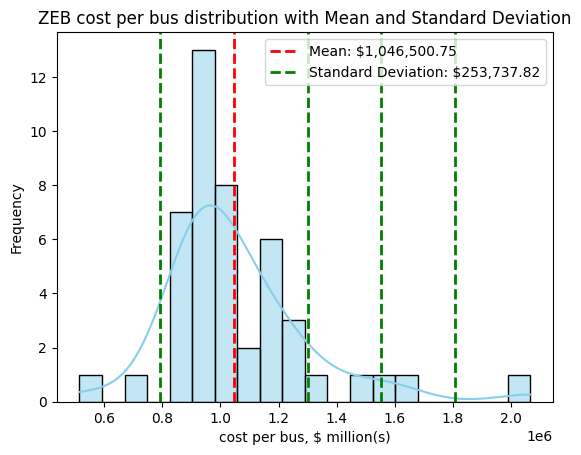

In [36]:
# ZEB cost per bus 
display(Markdown(
    "## What is the distribution of ZEB cost?"
))
dist_curve(
    df=zeb_projects,
    #using the accounting, weighted average approach to mean (total cost/total number of buses)
    mean=zeb_cpb_wt_avg,
    # need to investigate if std needs to be weighted as well?
    std=zeb_projects["cost_per_bus"].std(),
    title="ZEB cost per bus distribution",
    xlabel="cost per bus, $ million(s)",
)


In [37]:
dist_narrative = """This distribution show the ZEB cost floating around `~$1,000,000`, with only a few instances extending past +/- 1 standard deviation. 
As shown earlier, the lowest cost per ZEB bus was about `~$500,000`. However it should be noted that the propulsion type for this instance did not specify exactly which type of ZEB was procured (BEB, FCEB, or otherwise). 
The highest cost per ZEB was about `~$2,000,000` for BEB."""

display(
    Markdown(dist_narrative)
)

This distribution show the ZEB cost floating around `~$1,000,000`, with only a few instances extending past +/- 1 standard deviation. 
As shown earlier, the lowest cost per ZEB bus was about `~$500,000`. However it should be noted that the propulsion type for this instance did not specify exactly which type of ZEB was procured (BEB, FCEB, or otherwise). 
The highest cost per ZEB was about `~$2,000,000` for BEB.

## What is the cost per bus compared against all propulsion types?

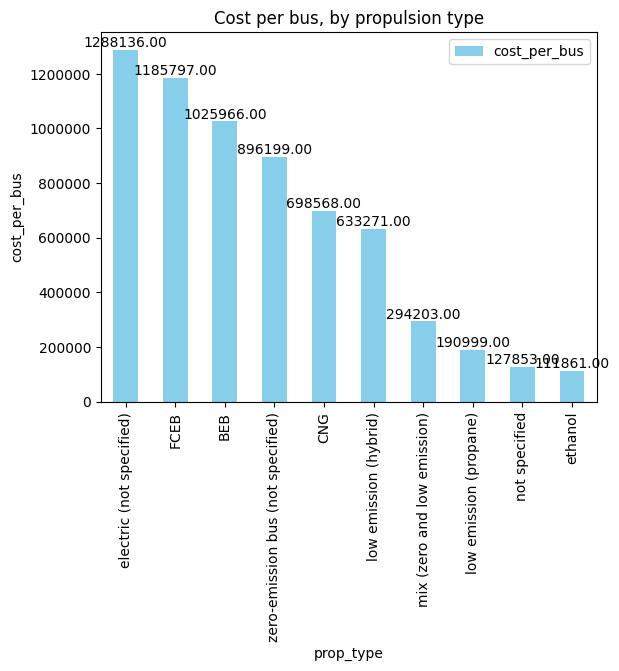

None

In [38]:
#
display(Markdown(
    "## What is the cost per bus compared against all propulsion types?"
))
display(
# cpb by prop type
make_chart("cost_per_bus", "Cost per bus, by propulsion type", x_col="prop_type", data=agg_prop[agg_prop["prop_type"] != "grand total"]),

# pivot table to
#agg_prop[["prop_type","new_cost_per_bus"]].sort_values(by="new_cost_per_bus", ascending=False).style.hide(axis="index")
)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## What is the total bus counts compared to each propulsion type?

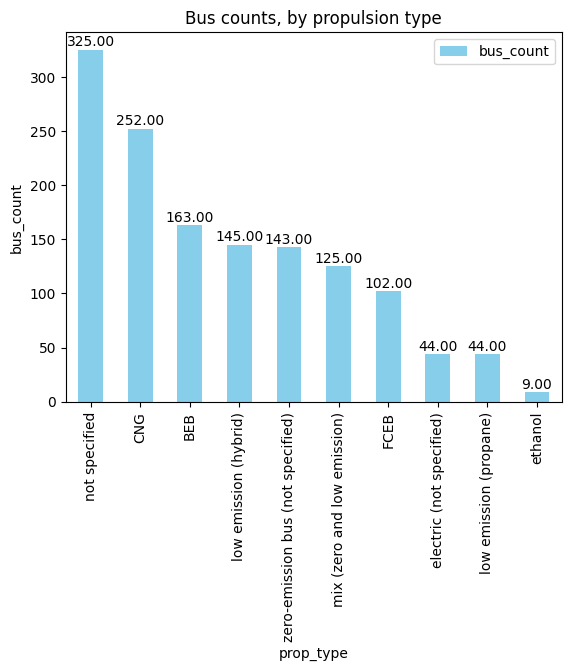

None

In [39]:
display(Markdown(
    "## What is the total bus counts compared to each propulsion type?"
))

display(
# bus count by prop type
make_chart("bus_count", "Bus counts, by propulsion type", x_col="prop_type", data=agg_prop[agg_prop["prop_type"] != "grand total"]),
# pivot table to
#agg_prop[["prop_type","total_bus_count"]].sort_values(by="total_bus_count", ascending=False).style.hide(axis="index")
)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## What is the total bus counts compared to each bus size category?

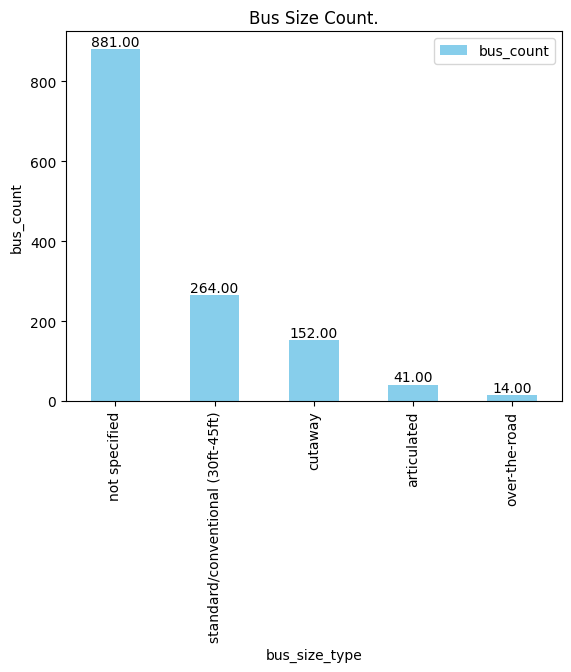

Unforunately, many of the projects did not specifiy any information indicating a bus size type. However we can breakdown other categories that provide a little more insight to bus sizes.

In [40]:
#bus size bar chart
display(
    Markdown("## What is the total bus counts compared to each bus size category?")
)

make_chart("bus_count", """Bus Size Count.""",  
           x_col="bus_size_type", 
           data=agg_bus_size[agg_bus_size["bus_size_type"] != "grand total"])
#agg_bus_size[["bus_size_type","total_bus_count"]].style.hide(axis="index")

display(
    Markdown("Unforunately, many of the projects did not specifiy any information indicating a bus size type. However we can breakdown other categories that provide a little more insight to bus sizes.")
)


<br>
<br>
<br>
<br>
<br>
<br>

In [41]:
display(
    Markdown("## What is the breakdown of ZEB Propulsion Type and Bus Size Category?"),
    pivot_size.loc[zeb_list],
    Markdown("We can obseve in this table that, when aggregated against propultion type, the standard bus size (30ft-45ft) is the most common size categorty for ZEBs")
)

## What is the breakdown of ZEB Propulsion Type and Bus Size Category?

bus_count  \
prop_type                         bus_size_type                                  
BEB                               articulated                             12.0   
                                  standard/conventional (30ft-45ft)      151.0   
FCEB                              not specified                           29.0   
                                  standard/conventional (30ft-45ft)       73.0   
electric (not specified)          articulated                             29.0   
                                  not specified                           15.0   
zero-emission bus (not specified) not specified                          143.0   

                                                                     total_cost  \
prop_type                         bus_size_type                                   
BEB                               articulated                          18759576   
                                  standard/conventional (30ft-45ft)   148472913   
FCEB                              not specified                        38070971   
                                  standard/conventional (30ft-45ft)    82880364   
electric (not specified)          articulated                          39478000   
                                  not specified                        17200000   
zero-emission bus (not specified) not specified                       128156513   

                                                                     cost_per_bus  
prop_type                         bus_size_type                                    
BEB                               articulated                             1563298  
                                  standard/conventional (30ft-45ft)        983264  
FCEB                              not specified                           1312792  
                                  standard/conventional (30ft-45ft)       1135347  
electric (not specified)          articulated                             1361310  
                                  not specified                           1146666  
zero-emission bus (not specified) not specified                            896199

We can obseve in this table that, when aggregated against propultion type, the standard bus size (30ft-45ft) is the most common size categorty for ZEBs

<br>

In [42]:
conclusion = f"""
# **Conclusion**

Based on these findings, The average cost of a ZEB, throughout the US, is `~$1,000,000`, roughly twice the price of a conventional, non-ZEB. 
The most commonly procured BEBs and FCEBs are the standard 30ft-45ft category, costing `~$980,000` and `~$110,000` respectively.
The variance in cost depends mainly on the options the Transit Agencies chooses. Highly optioned/customized buses contribute to higher cost.
Unfortunately, analyzing the cost of configurable options is outside the scope of data provided. 
 
"""
display(
    Markdown(conclusion)
)


# **Conclusion**

Based on these findings, The average cost of a ZEB, throughout the US, is `~$1,000,000`, roughly twice the price of a conventional, non-ZEB. 
The most commonly procured BEBs and FCEBs are the standard 30ft-45ft category, costing `~$980,000` and `~$110,000` respectively.
The variance in cost depends mainly on the options the Transit Agencies chooses. Highly optioned/customized buses contribute to higher cost.
Unfortunately, analyzing the cost of configurable options is outside the scope of data provided. 
 


<br>
<br>

In [43]:
# appendix doesnt print to pdf nicely
# disabling for now

#display(
#    Markdown(f"""# Appendix
#    Dataset"""),
#    merged_data
#)